<a href="https://colab.research.google.com/github/tmgrgg/nlp-mafiascum/blob/master/LSTM_Mafiascum_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#We'll need this to be able to cache stuff without blowing up RAM

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import torch
from torchtext import data
from torchtext import datasets
import random
import numpy as np

#SEED = 49
#pretty good 

SEED = 49
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

DOCS_PATH = 'drive/My Drive/MAFIA_DATA/24h_of_deception_basic.pkl'

docs = pd.read_pickle(DOCS_PATH)
docs = docs.sample(frac=1)

print(len(docs))

TEST_RATIO = 0.5
VALID_RATIO = 0.3

# split at user level to stop leakage (plus, we want to be agnostic to author identity!)
users = docs.author.unique()
np.random.shuffle(users)

train_users = users[int(len(users)*TEST_RATIO):]
test_users = users[:int(len(users)*TEST_RATIO)]
valid_users = train_users[:int(len(train_users)*VALID_RATIO)]
train_users = train_users[int(len(train_users)*VALID_RATIO):]

train_docs = docs[np.isin(docs['author'].values, train_users)]
valid_docs = docs[np.isin(docs['author'].values, valid_users)]
test_docs = docs[np.isin(docs['author'].values, test_users)]

print(docs.iloc[0]['author'] == 'Egg')
print(docs.iloc[1]['author'] == 'Wake88')
print(train_docs.iloc[0]['author'] == 'Egg')
print(train_docs.iloc[1]['author'] == 'Vendagoat')
print(valid_docs.iloc[0]['author'] == 'Wake88')
print(valid_docs.iloc[1]['author'] == 'OhGodMyLife')
print(test_docs.iloc[0]['author'] == 'Bellaphant')
print(test_docs.iloc[1]['author'] == 'Fishbulb')

print(len(train_docs[train_docs['scum'] == False])/len(train_docs))
print(len(valid_docs[valid_docs['scum'] == False])/len(valid_docs))
print(len(test_docs[test_docs['scum'] == False])/len(test_docs))

112523
False
False
False
False
False
False
False
False
0.7640725776093558
0.76381299332119
0.7598832864818703


# Build Dataset


In [0]:
from torchtext import data

class DataFrameDataset(data.Dataset):

    def __init__(self, df, text_field, label_field, **kwargs):
        fields = [('text', text_field), ('label', label_field), ('index', Field(sequential=False, use_vocab=False))]
        examples = []
        for i, row in df.iterrows():
            label = row.scum 
            text = row.words
            examples.append(data.Example.fromlist([text, label, i], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

from torchtext.data import Field, LabelField

# define Fields
TEXT = Field(sequential=True, include_lengths=True)
LABEL = LabelField(dtype=torch.float)
#LABEL = LabelField(dtype=torch.long)

# define Dataset
#train_data = 
#dataset = DataFrameDataset(docs, TEXT, LABEL)
train_data = DataFrameDataset(train_docs, TEXT, LABEL)
valid_data = DataFrameDataset(valid_docs, TEXT, LABEL)
test_data = DataFrameDataset(test_docs, TEXT, LABEL)

#train_data, test_data = dataset.split(split_ratio=0.8, random_state=random.seed(SEED))
#train_data, valid_data = train_data.split(split_ratio = 0.8, random_state= random.seed(SEED))

# Specify Model

In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
        
            
        return self.fc(hidden)

# TRAINING

## Training Utilities

In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [0]:
from sklearn.metrics import roc_auc_score, average_precision_score

def train(model, iterator, optimizer, criterion, weight_by_length=False):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    all_predictions = []
    all_y_true = []
    
    for batch in iterator:       
        optimizer.zero_grad()

        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
                
        loss = criterion(predictions, batch.label)

        if weight_by_length:
          sample_weight = torch.log(text_lengths.float())
          #print(sample_weight)
          loss = sample_weight * loss

        loss = loss.mean()
              
        # since we're using reduction = none we have to use loss.mean()
        loss.backward()
        
        optimizer.step()

        acc = binary_accuracy(predictions, batch.label)

        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        all_predictions.append(predictions.cpu().detach().numpy())
        all_y_true.append(batch.label.cpu().detach().numpy())

    
    all_y_true = np.hstack(all_y_true)
    all_predictions = np.hstack(all_predictions)
    auc_score = roc_auc_score(all_y_true, all_predictions)   
    ap_score = average_precision_score(all_y_true, all_predictions) 
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator), auc_score, ap_score

In [0]:
def evaluate(model, iterator, criterion, weight_by_length=False):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        all_predictions = []
        all_y_true = []
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)        
                
            loss = criterion(predictions, batch.label)

            if weight_by_length:
              sample_weight = torch.log(text_lengths.float())
              #print(sample_weight)
              loss = sample_weight * loss
            
            loss = loss.mean()

            acc = binary_accuracy(predictions, batch.label)

            all_predictions.append(predictions.cpu().numpy())
            all_y_true.append(batch.label.cpu().numpy())

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    all_y_true = np.hstack(all_y_true)
    all_predictions = np.hstack(all_predictions)
    auc_score = roc_auc_score(all_y_true, all_predictions)   
    ap_score = average_precision_score(all_y_true, all_predictions)  
    return epoch_loss / len(iterator), epoch_acc / len(iterator), auc_score, ap_score

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import OrderedDict

class StatsTracker():
  def __init__(self, plot_freq=5):
    self.counter = 0
    self.plot_freq = plot_freq
    self._metrics = OrderedDict({})

  def _make_plot(self):
      fig, ax = plt.subplots(1, len(self._metrics.keys()), squeeze=False, figsize=(18,4))
      for i, metric in enumerate(self._metrics.keys()):
        train_metric = self._metrics[metric]['train']
        valid_metric = self._metrics[metric]['valid']
        ax[0, i].plot(list(range(len(train_metric))), train_metric, c='b', label='Train', marker='.')
        ax[0, i].plot(list(range(len(valid_metric))), valid_metric, c='r', label='Valid', marker='.')
        ax[0, i].set_ylabel(metric)
        ax[0, i].set_xlabel('epochs')
        ax[0, i].legend(loc='upper right')

  def plot(self):
    # will plot the current loss_graph every plot_freq^th call to plot
    self.counter += 1
    if (self.counter % self.plot_freq == 0):
      print('hey')
      fig = self._make_plot()
      clear_output()
      plt.show()
      #fig.close()

  def save(self, path):
    # save the current loss_graph to the given path
    self._make_plot()
    plt.savefig(path)
    plt.close()

  def log(self, value, metric, setting='train'):
    assert(setting == 'train' or setting == 'valid')
    if metric not in self._metrics.keys():
      self._metrics[metric] = {'train': [], 'valid': []}
    self._metrics[metric][setting].append(value)

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Define Model Paramters and Training Hyperparameters

In [10]:
MAX_VOCAB_SIZE = 25_000
 #fasttext.en.300d
TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:26, 2.23MB/s]                          
100%|█████████▉| 399978/400000 [00:14<00:00, 25874.17it/s]

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator =  data.BucketIterator(train_data, batch_size = BATCH_SIZE, train=True, sort=True,
                                      sort_within_batch = True, device = device)

valid_iterator =  data.BucketIterator(valid_data, train=False, sort=True, batch_size = BATCH_SIZE, 
                                      sort_within_batch = True, device = device)

tensor(0.2359)
tensor(0.2362)


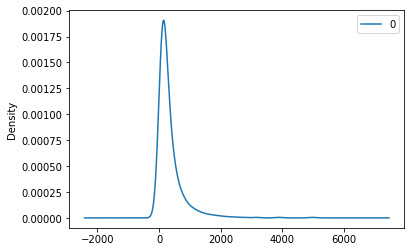

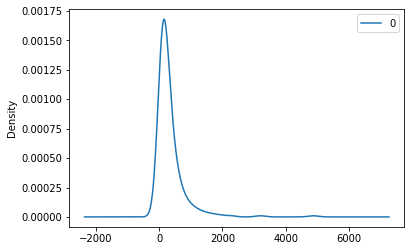

In [12]:
# check distributions

train_lens = []
valid_lens = []
train_positives = 0
train_length = 0
valid_positives = 0
valid_length = 0

for batch in train_iterator:
  train_lens.append(batch.text[0].cpu().shape[0])
  train_positives += batch.label.cpu().sum()
  train_length += len(batch.label)

for batch in valid_iterator:
  valid_lens.append(batch.text[0].cpu().shape[0])
  valid_positives += batch.label.cpu().sum()
  valid_length += len(batch.label)


pd.DataFrame(train_lens).plot.kde()
pd.DataFrame(valid_lens).plot.kde()
print(train_positives/train_length)
print(valid_positives/valid_length)

In [13]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = TEXT.vocab.vectors.shape[1]
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

model.embedding.weight.data.copy_(pretrained_embeddings)
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

torch.Size([25002, 100])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [ 0.2733,  0.1248,  0.9567,  ..., -0.4712,  0.2465,  0.8924],
        [-0.0839, -0.5739, -0.2368,  ..., -0.0162, -0.2855,  0.7073],
        [ 0.0985, -0.4974, -0.1092,  ..., -0.0620, -0.4713, -0.0628]])


In [14]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)#, lr=0.001, weight_decay=0.002)

pos_weight = len(docs[docs['scum'] == False])/len(docs[docs['scum'] == True])

print(pos_weight)

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([pos_weight]), reduction='none')
#criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

3.2006570351289803


## Training Loop

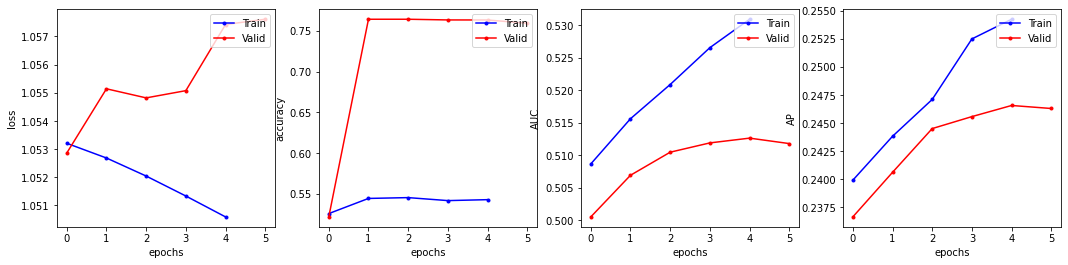

Epoch: 05 | Epoch Time: 1m 49s
	Train Loss: 1.051 | Train Acc: 54.27% | Train AUC: 0.531 | Train AP: 0.254
	 Val. Loss: 1.058 |  Val. Acc: 75.92% | Val. AUC: 0.512 | Val. AP: 0.246


In [0]:
N_EPOCHS = 50
WEIGHT_BY_LENGTH = False

best_valid_loss = float('inf')
tracker = StatsTracker(plot_freq=1)
valid_loss, valid_acc, valid_auc, valid_ap = evaluate(model, valid_iterator, criterion, weight_by_length=WEIGHT_BY_LENGTH)
tracker.log(valid_loss, 'loss', setting='valid')
tracker.log(valid_acc, 'accuracy', setting='valid')
tracker.log(valid_auc, 'AUC', setting='valid')
tracker.log(valid_ap, 'AP', setting='valid')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc, train_auc, train_ap = train(model, train_iterator, optimizer, 
                                                      criterion, weight_by_length=WEIGHT_BY_LENGTH)
    valid_loss, valid_acc, valid_auc, valid_ap = evaluate(model, valid_iterator, criterion, weight_by_length=WEIGHT_BY_LENGTH)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')

    tracker.log(train_loss, 'loss', setting='train')
    tracker.log(valid_loss, 'loss', setting='valid')
    tracker.log(train_acc, 'accuracy', setting='train')
    tracker.log(valid_acc, 'accuracy', setting='valid')
    tracker.log(train_auc, 'AUC', setting='train')
    tracker.log(valid_auc, 'AUC', setting='valid')
    tracker.log(train_ap, 'AP', setting='train')
    tracker.log(valid_ap, 'AP', setting='valid')
    tracker.plot()

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train AUC: {train_auc:.3f} | Train AP: {train_ap:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Val. AUC: {valid_auc:.3f} | Val. AP: {valid_ap:.3f}')

# write results for future reference ;)
save_path = 'drive/My Drive/model_LSTM:HIDDEN_DIM[{}]_N_LAYERS[{}]_BIDIRECTIONAL[{}]_DROPOUT[{}]_VOCAB_SIZE[{}]_EMBED[{}]_OPTIM[{}]_WEIGHT_BY_LENGTH[{}]'.format(
    HIDDEN_DIM, 
    N_LAYERS, 
    BIDIRECTIONAL, 
    DROPOUT, 
    MAX_VOCAB_SIZE,
    EMBEDDING_NAME,
    '_'.join(str(optimizer).split('\n')),
    WEIGHT_BY_LENGTH
)

INPUT_DIM, 
           
tracker.save(save_path + '.png')

## Check Performance on Test Set

In [0]:
model.load_state_dict(torch.load('best-lstm.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')